In [1]:
import random 
import numpy as np 
import torch 
from utilities.pg_utils import set_seed
#set_seed(112)

In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


from typing import List
import torch 
from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
end_date = "2024-09-30"
N_EPISODES = 150  # number of episodes to train the agent
N_ITERATIONS_PER_EPISODE = 20
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date, end_date=end_date)
# kraken_ds = KrakenDataSet(portfolio, WINDOW_SIZE)
agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
agent.pre_train()
# train the agent


pre-training ddpg agent started...
ReplayMemoryBuffer populating with experience...
pretraining done
buffer size: 13071


In [3]:
def calculate_total_return(equity_curve):
    """
    Calculate the total return from an equity curve.

    Args:
        equity_curve (list): List of portfolio values over time.

    Returns:
        float: Total return as a percentage.
    """
    V_start = equity_curve[0]
    V_end = equity_curve[-1]
    total_return = ((V_end - V_start) / V_start) * 100
    return total_return

In [4]:
calculate_total_return()

TypeError: calculate_total_return() missing 1 required positional argument: 'equity_curve'

In [5]:

import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)


Training Started for DDPG Agent
Episode 1 - Actor Loss: -0.0081, Critic Loss: 1.0069, Total Reward: 6.5134
Episode 2 - Actor Loss: -0.0207, Critic Loss: 1.0441, Total Reward: 8.0757
Episode 3 - Actor Loss: -0.0410, Critic Loss: 1.5878, Total Reward: 8.3290
Episode 4 - Actor Loss: -0.0589, Critic Loss: 1.0490, Total Reward: 6.5682
Episode 5 - Actor Loss: -0.0753, Critic Loss: 0.9871, Total Reward: 6.0038
Episode 6 - Actor Loss: -0.0962, Critic Loss: 0.9550, Total Reward: 6.9668
Episode 7 - Actor Loss: -0.1108, Critic Loss: 1.0597, Total Reward: 6.4082
Episode 8 - Actor Loss: -0.1270, Critic Loss: 0.8696, Total Reward: 6.0199
Episode 9 - Actor Loss: -0.1463, Critic Loss: 1.1023, Total Reward: 7.3513
Episode 10 - Actor Loss: -0.1595, Critic Loss: 0.8528, Total Reward: 5.9107
Episode 11 - Actor Loss: -0.1773, Critic Loss: 1.0841, Total Reward: 5.5178
Episode 12 - Actor Loss: -0.1923, Critic Loss: 1.0309, Total Reward: 6.4818
Episode 13 - Actor Loss: -0.2086, Critic Loss: 1.0135, Total Rewa

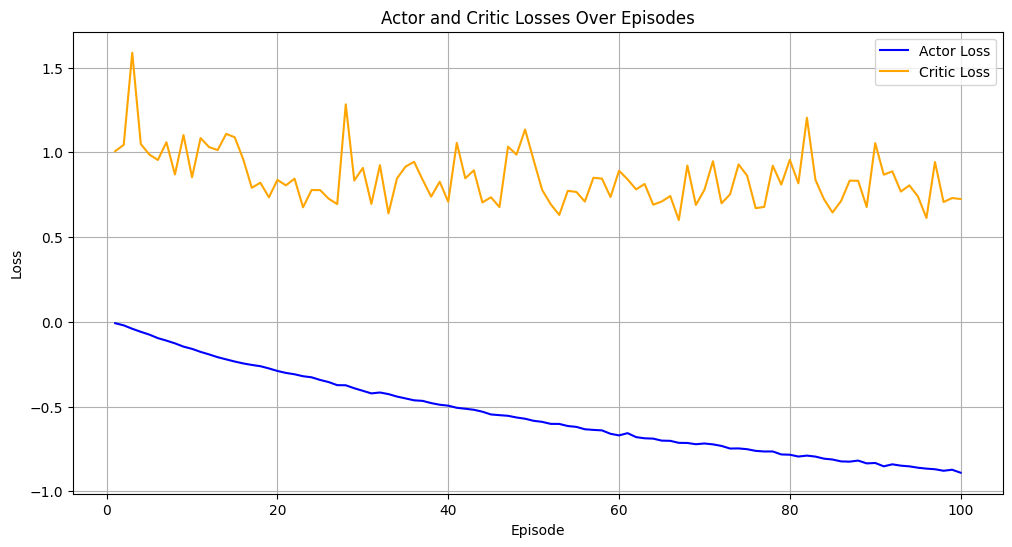

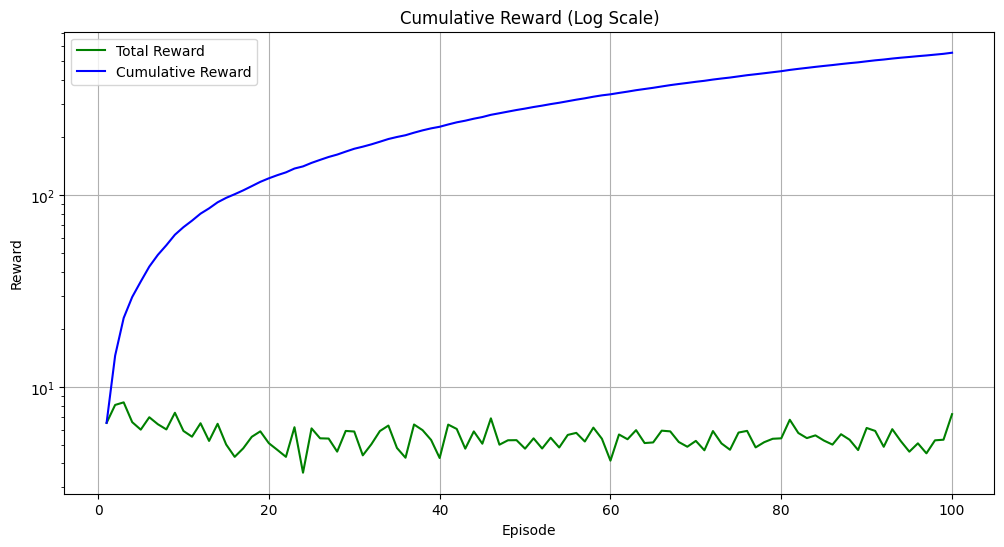

In [6]:
# train agent
agent.train(100);

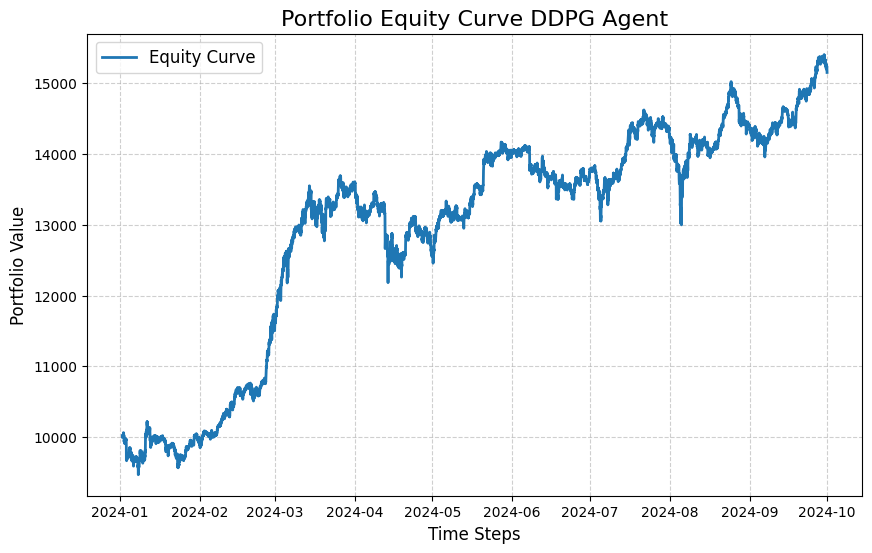

In [7]:
# checking pvm as it should be similar to buy and hold prior to training
import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)
cl_price = portfolio.get_close_price()
dates = cl_price.index


pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []

for i in range(len(ds) + 49):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    wt_cash = 1 - wt.sum()
    wt = torch.concat([wt_cash.unsqueeze(0), wt], dim=-1)
    weights.append(wt)
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current

# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[49:], agent_equity_curve, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve DDPG Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [15]:
prev_index

13119

In [8]:
calculate_total_return(agent_equity_curve)

51.517392578125

In [11]:
calculate_total_return(agent_equity_curve)

73.18025390625

In [ ]:
portfolio.asset_names

In [10]:
weights[-5:]

[tensor([0.0007, 0.0858, 0.0921, 0.0877, 0.0901, 0.0906, 0.0964, 0.0929, 0.0884,
         0.0967, 0.0849, 0.0937], device='mps:0'),
 tensor([0.0007, 0.0867, 0.0901, 0.0867, 0.0904, 0.0911, 0.0963, 0.0955, 0.0876,
         0.0964, 0.0844, 0.0942], device='mps:0'),
 tensor([0.0006, 0.0867, 0.0917, 0.0846, 0.0915, 0.0915, 0.0980, 0.0968, 0.0865,
         0.0964, 0.0823, 0.0934], device='mps:0'),
 tensor([0.0007, 0.0871, 0.0929, 0.0831, 0.0913, 0.0912, 0.0975, 0.1038, 0.0851,
         0.0946, 0.0809, 0.0918], device='mps:0'),
 tensor([0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
         0.0833, 0.0833, 0.0833], device='mps:0')]

In [15]:
agent.pvm.memory[13118:13120]

tensor([[0.0348, 0.0337, 0.0352, 0.0335, 0.0335, 0.0324, 0.0327, 0.0344, 0.0324,
         0.0358, 0.0331],
        [0.0358, 0.0346, 0.0364, 0.0346, 0.0347, 0.0335, 0.0329, 0.0357, 0.0342,
         0.0370, 0.0342]], device='mps:0')

In [ ]:
"""# buy and hold
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 48):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve Buy And Hold", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()
"""

Reward Min: -13.616040411241164, Reward Max: 12.29442593849761
Reward Mean: 0.303645705888974, Reward Std: 0.904636655753166


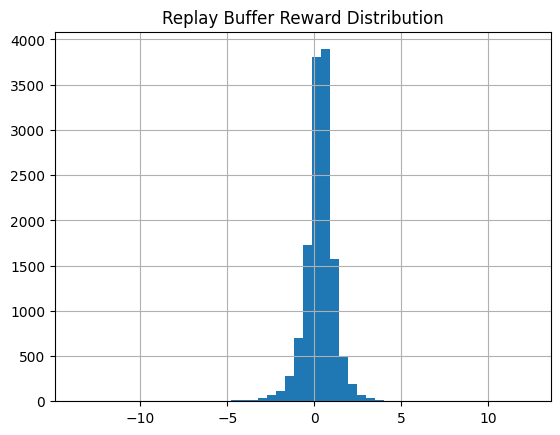

In [10]:
import matplotlib.pyplot as plt
rewards = [exp.reward for exp in agent.replay_memory.buffer]
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")

plt.grid()

In [11]:
sampled_actions = torch.stack([exp.action for exp in agent.replay_memory.buffer])
action_variances = torch.var(sampled_actions, dim=0)
print("Action Variance per Dimension:", action_variances)

Action Variance per Dimension: tensor([0.0008, 0.0007, 0.0008, 0.0007, 0.0008, 0.0007, 0.0008, 0.0007, 0.0008,
        0.0008, 0.0008], device='mps:0')


In [12]:
import pandas as pd
action_correlation = torch.corrcoef(sampled_actions.T)  # Correlation matrix
print("Action Correlation Matrix:", pd.DataFrame(action_correlation.cpu().numpy()))

Action Correlation Matrix:           0         1         2         3         4         5         6   \
0   1.000000 -0.101333 -0.094376 -0.080896 -0.073123 -0.075355 -0.103095   
1  -0.101333  1.000000 -0.100170 -0.087273 -0.095921 -0.069975 -0.069231   
2  -0.094376 -0.100170  1.000000 -0.098555 -0.088030 -0.061621 -0.082694   
3  -0.080896 -0.087273 -0.098555  1.000000 -0.083296 -0.118023 -0.091557   
4  -0.073123 -0.095921 -0.088030 -0.083296  1.000000 -0.081092 -0.099040   
5  -0.075355 -0.069975 -0.061621 -0.118023 -0.081092  1.000000 -0.109867   
6  -0.103095 -0.069231 -0.082694 -0.091557 -0.099040 -0.109867  1.000000   
7  -0.106162 -0.069920 -0.060652 -0.101811 -0.092976 -0.068587 -0.080323   
8  -0.088781 -0.088094 -0.126755 -0.088583 -0.097762 -0.074550 -0.083680   
9  -0.091094 -0.096717 -0.061734 -0.081043 -0.097481 -0.080310 -0.101453   
10 -0.064026 -0.090225 -0.114215 -0.066316 -0.065420 -0.110970 -0.082146   

          7         8         9         10  
0  -0.106162 -0

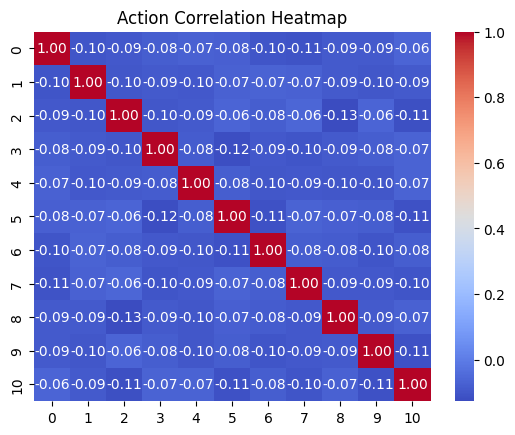

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(action_correlation.cpu().numpy(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Action Correlation Heatmap")
plt.show()

In [14]:
import scipy.stats
entropy = [scipy.stats.entropy(sampled_actions[:, i].cpu().numpy()) for i in range(11)]
print("Entropy per Weight:", entropy)

Entropy per Weight: [np.float64(9.418611564736073), np.float64(9.419666147758543), np.float64(9.41731067630194), np.float64(9.419775273116501), np.float64(9.417957159401332), np.float64(9.420403271272761), np.float64(9.4174627327655), np.float64(9.41993713873983), np.float64(9.417916407625956), np.float64(9.416842715405739), np.float64(9.418583427573104)]


In [15]:
from scipy.spatial.distance import pdist, squareform
pairwise_distances = pdist(sampled_actions.cpu().numpy())
mean_distance = np.mean(pairwise_distances)
print("Mean Pairwise Distance:", mean_distance)

Mean Pairwise Distance: 0.10461021413291548


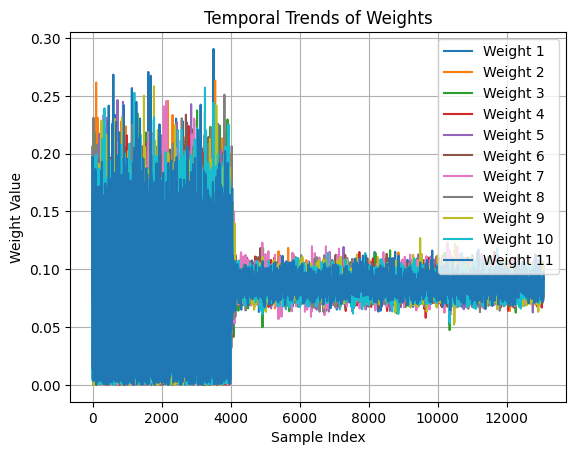

In [16]:
plt.grid();
for i in range(11):
    plt.plot(sampled_actions[:, i].cpu().numpy(), label=f"Weight {i+1}")
plt.title("Temporal Trends of Weights")
plt.xlabel("Sample Index")
plt.ylabel("Weight Value")
plt.legend()
plt.show()

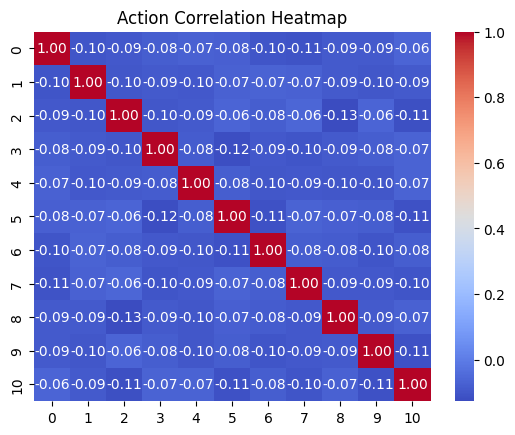

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(action_correlation.cpu().numpy(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Action Correlation Heatmap")
plt.show()

In [18]:
action_means = torch.mean(sampled_actions, dim=0)
action_ranges = torch.max(sampled_actions, dim=0).values - torch.min(sampled_actions, dim=0).values
print("Action Means:", action_means)
print("Action Ranges:", action_ranges)

Action Means: tensor([0.0855, 0.0854, 0.0846, 0.0858, 0.0851, 0.0854, 0.0858, 0.0852, 0.0851,
        0.0846, 0.0856], device='mps:0')
Action Ranges: tensor([0.2906, 0.2632, 0.2374, 0.2507, 0.2463, 0.2351, 0.2454, 0.2510, 0.2582,
        0.2571, 0.2675], device='mps:0')
